In [1]:
import os
import sys
import csv

sys.path.append(os.path.dirname(os.getcwd()))

import matplotlib.pyplot as plt
import numpy as np

from utils.dataset import train_test_load
from utils.checkpoint import save_params, load_params

from model.train.recommender import training_loop, update_params

In [2]:
test_split = 0.2

train, test = train_test_load("../data/ml-32m/ratings.csv", "../data/ml-32m/movies.csv", test_split=test_split)

### Training

In [3]:
train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    embedding_dim = 10, r_lambda = 0.1, r_gamma = 0.1, r_tau = 0.1, n_iter = 50,
)

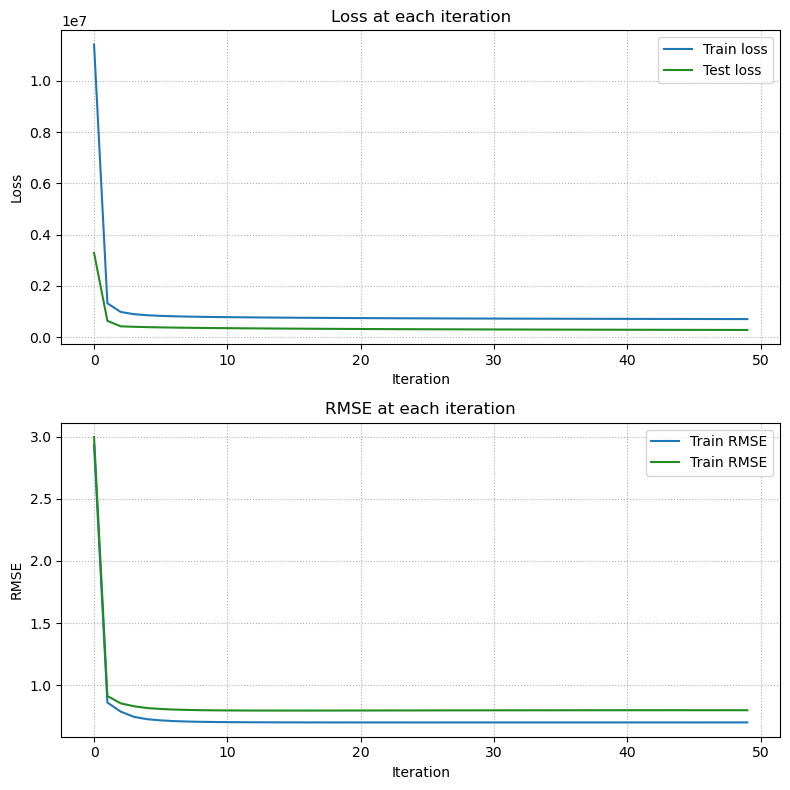

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_10.svg", format="svg")
plt.show()

In [7]:
# save_params("../artifacts/model/32m_users_training_10.param", train.idx_to_user_id, user_embeddings, user_bias)
# save_params("../artifacts/model/32m_movie_training_10.param", train.idx_to_movie_id, movie_embeddings, movie_bias)

In [8]:
train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    embedding_dim = 20, r_lambda = 0.1, r_gamma = 0.1, r_tau = 0.1, n_iter = 50,
)

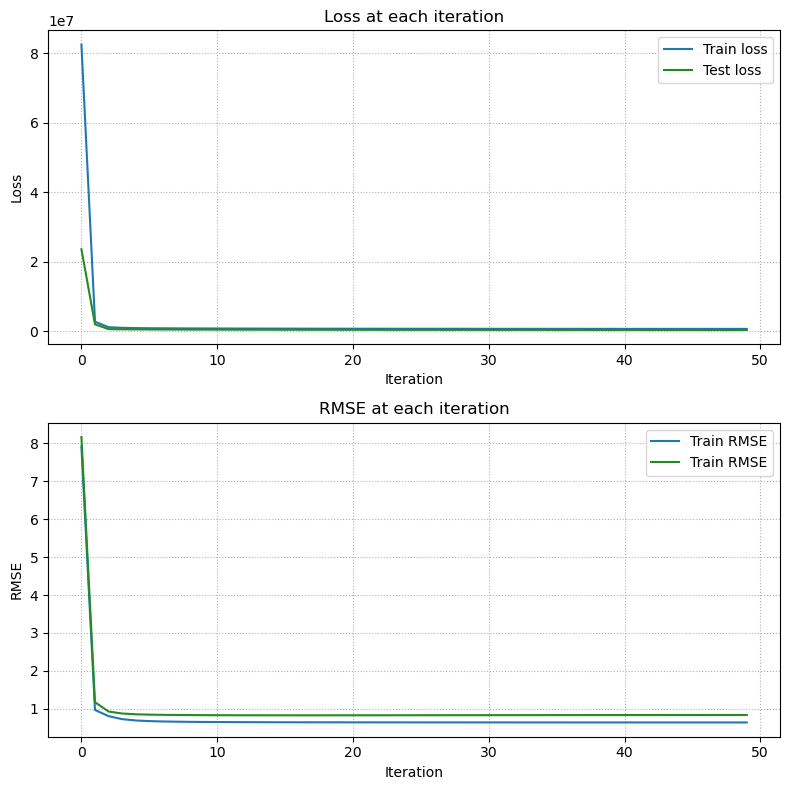

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_20.svg", format="svg")
plt.show()

In [11]:
# save_params("../artifacts/model/32m_users_training_20.param", train.idx_to_user_id, user_embeddings, user_bias)
# save_params("../artifacts/model/32m_movie_training_20.param", train.idx_to_movie_id, movie_embeddings, movie_bias)

### Experiments

#### Loading saved embedding

In [2]:
idx_to_user_id, user_embeddings, user_bias = load_params("../artifacts/model/32m_users_training_20.param")
idx_to_movie_id, movie_embeddings, movie_bias = load_params("../artifacts/model/32m_movie_training_20.param")

#### Loading data

In [3]:
user_id_to_idx = {v:k for k, v in enumerate(idx_to_user_id)}
movie_id_to_idx = {v:k for k, v in enumerate(idx_to_movie_id)}

user_movie = [([],[]) for _ in range(len(idx_to_user_id))]
movie_user = [([],[]) for _ in range(len(idx_to_movie_id))]

with open("../data/ml-32m/ratings.csv") as f:
    reader = csv.reader(f)
    _ = next(reader)
    for row in reader:
        user_id, movie_id, rating, _ = row
        user_idx = user_id_to_idx[user_id]
        movie_idx = movie_id_to_idx[movie_id]
        user_movie[user_idx][0].append(movie_idx)
        user_movie[user_idx][1].append(float(rating))
        movie_user[movie_idx][0].append(user_idx)
        movie_user[movie_idx][1].append(float(rating))

movie_id_to_title = {}
title_to_movie_id = {}

with open("../data/ml-32m/movies.csv") as f:
    reader = csv.reader(f)
    _ = next(reader)
    for row in reader:
        movie_id, title, _ = row
        movie_id_to_title[movie_id] = title
        title_to_movie_id[title] = movie_id

#### Adding dummy user

In [4]:
lord_of_the_ring_idx = movie_id_to_idx[title_to_movie_id["Lord of the Rings, The (1978)"]]
lord_of_the_ring_rating = 5.0

dummy_id = "dummy"
dummy_idx = len(user_id_to_idx)
user_id_to_idx[dummy_id] = dummy_idx
idx_to_user_id.append(dummy_id)

user_movie.append((
    [lord_of_the_ring_idx], [lord_of_the_ring_rating]
))

movie_user[lord_of_the_ring_idx][0].append(dummy_idx)
movie_user[lord_of_the_ring_idx][1].append(lord_of_the_ring_rating)

user_embeddings = np.vstack([user_embeddings, np.random.normal(0, np.sqrt(user_embeddings.shape[1]), (user_embeddings.shape[1]))])

In [7]:
assert len(user_embeddings) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"

#### Update embedding

In [5]:
for i in range(len(user_movie)):
    user_movie[i] = (
        np.array(user_movie[i][0], dtype=int),
        np.array(user_movie[i][1], dtype=np.float64),
    )

for i in range(len(movie_user)):
    movie_user[i] = (
        np.array(movie_user[i][0], dtype=int),
        np.array(movie_user[i][1], dtype=np.float64),
    )

In [26]:
old_embedding = user_embeddings[dummy_idx].copy()

In [27]:
for _ in range(5):
    update_params(
        movie_user,
        user_movie,
        user_embeddings.shape[1],
        0.1,
        0.1,
        0.1,
        user_bias,
        movie_bias,
        user_embeddings,
        movie_embeddings
    )

In [33]:
assert ((old_embedding - user_embeddings[dummy_idx]) > 1e-2).any(), "Embedding not upadated"

#### Top 20 Movies

In [34]:
movie_scores = movie_embeddings @ user_embeddings[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

In [41]:
print("Top 20 Prediction")

for i, idx in enumerate(reversed(dummy_movie_ranks[-20:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title)

Top 20 Prediction
1 - Lord of the Rings, The (1978)
2 - Star Wars: Episode II - Attack of the Clones (2002)
3 - Dune (1984)
4 - Star Wars: Episode IV - A New Hope (1977)
5 - Star Wars: Episode I - The Phantom Menace (1999)
6 - Star Wars: Episode VI - Return of the Jedi (1983)
7 - Star Wars: Episode V - The Empire Strikes Back (1980)
8 - Star Wars: Episode III - Revenge of the Sith (2005)
9 - Heavy Metal (1981)
10 - Tron (1982)
11 - Black Hole, The (1979)
12 - Conan the Barbarian (1982)
13 - Dark Crystal, The (1982)
14 - Star Wars: The Clone Wars (2008)
15 - Excalibur (1981)
16 - Highlander (1986)
17 - Lord of the Rings: The Two Towers, The (2002)
18 - Lord of the Rings: The Fellowship of the Ring, The (2001)
19 - Lord of the Rings: The Return of the King, The (2003)
20 - 2010: The Year We Make Contact (1984)
